In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## 1. Problem Statement

In this notebook, we study iterative stochastic optimization methods designed for solving large-scale empirical risk minimization problems of the form:
$$\min_{x \in \mathbb{R}^d} F(x),$$


where:
- $F(x) = \frac{1}{n} \sum_{i=1}^n f_i(x)$
- $f_i(x)$ is the loss of model $ x $ evaluated on the $i$-th sample,
- $n$ may be extremely large,
- computing the full gradient
  $\nabla F(x) = \frac{1}{n} \sum_{i=1}^n \nabla f_i(x)$
  is computationally expensive or infeasible per iteration.

The optimization problem assumes the following structure:

### Assumptions

1. Smoothness  
   Each function  $f_i$ is $L$-smooth, i.e.
$\|\nabla f_i(x) - \nabla f_i(y)\| \le L \|x - y\|.$ 

2. Convexity (when required)  
   In some analyses we may assume that  $F(x)$  is convex:
$   F(y) \ge F(x) + \langle \nabla F(x), y - x \rangle.$  

3. Stochastic Gradient Unbiasedness  
   At each iteration, a random sample $i_k$ is selected uniformly and we define:
$   g_k = \nabla f_{i_k}(x_k),$   
   with expectation: $ \mathbb{E}[g_k \mid x_k] = \nabla F(x_k).$   

4. Bounded Variance of Stochastic Gradients  
   There exists $\sigma^2 > 0$ such that: $ \mathbb{E}\|g_k - \nabla F(x_k)\|^2 \le \sigma^2.$   

## 2. Goal of the notebook

The goal of this work is to implement from scratch several foundational stochastic optimization algorithms, analyze their behavior, and experimentally compare their convergence properties. Specifically, we consider:

- Stochastic Gradient Descent (SGD)  
- SGD with Momentum (Polyak)  
- RMSProp  
- Adam

For each method, we aim to:

1. Derive the mathematical update rule.
2. Provide convergence properties.
3. Implement the algorithm from scratch using Python and Numpy.
4. Visualize optimization trajectories on a test function $f(x, y) = ax^2 + by^2$  exhibiting strong anisotropy.
5. Compare convergence rates empirically.
6. Draw conclusions about the relative strengths and weaknesses of each method.

## 3. Theory and implementations of methods

We study stochastic optimization on a family of quadratic functions. Each sample function is
$$
f_i(x) = \frac{1}{2}\, x^\top A_i x,
\qquad
\nabla f_i(x) = A_i x.
$$

We construct each matrix $A_i$ by adding symmetric Gaussian noise to a base matrix

$$A_{\text{base}} = 
\begin{pmatrix}
\mu & 0 \\
0 & \mu \kappa 
\end{pmatrix},$$

where $\mu$ is the strong convexity parameter, $k$ is the condition number.

We use an exponential learning rate schedule: $\alpha_t = \alpha_0 \cdot (\text{decay})^{t}.$

In [55]:
def make_quadratic_dataset(N=2000, dim=2, noise_scale=10.0, strong_convexity=1, condition_number=20):
    A_base = np.diag([strong_convexity, strong_convexity * condition_number])
    A_list = []
    for _ in range(N):
        noise = noise_scale * np.random.randn(dim, dim)
        noise = 0.5 * (noise + noise.T)
        A_i = A_base + noise
        A_i += 0.1 * np.eye(dim)
        A_list.append(A_i)
    return np.array(A_list)

def grad_f_i(x, A_i):
    return A_i @ x

def minibatch_grad(x, A_list, batch_size):
    idx = np.random.choice(len(A_list), batch_size, replace=False)
    grads = [grad_f_i(x, A_list[i]) for i in idx]
    return np.mean(grads, axis=0)

def lr_schedule(lr0, step, decay=0.99):
    return lr0 * (decay ** step)

### 3.1 Stochastic Gradient Descent

Instead of computing the full gradient, at iteration $k$ we randomly choose a subset (mini-batch) $B_k$ of size $b$, and approximate:

$g_k = \dfrac{1}{|B_k|} \sum_{i \in B_k} \nabla f_i(x_k)$.

Update rule:

$x_{k+1} = x_k - \eta_k g_k$.

The learning rate $\eta_k$ controls the trade-off between noise and progress.

In [56]:
def sgd_decay(x0, A_list, lr_vector, batch_size=64, steps=200, decay=0.99):
    x = x0.copy()
    traj = [x.copy()]
    for t in range(steps):
        g = minibatch_grad(x, A_list, batch_size)
        lr_t = lr_schedule(lr_vector, t, decay)
        x -= lr_t * g
        traj.append(x.copy())
    return np.array(traj)

Properties of SGD

- Unbiasedness:  $\quad \mathbb{E}[g_k | x_k] = \nabla F(x_k)$

- Bounded variance assumption:  $\quad \mathbb{E}\|g_k - \nabla F(x_k)\|^2 \le \sigma^2$

Convergence Theory

Under standard assumptions (convexity + L-smoothness):

- With constant learning rate SGD converges to a neighborhood around the minimum:

    $\lim_{k \to \infty} \mathbb{E}[F(x_k)] - F(x^*) = O(\eta \sigma^2)$.

- With decaying learning rate $\eta_k = \dfrac{1}{k}$, SGD achieves $F(x_k) - F(x^*) = O\left(\dfrac{1}{\sqrt{k}}\right)$.

 This rate is optimal for first-order stochastic optimization.

### 3.2 Momentum-Based Stochastic Gradient Descent

SGD suffers from slow convergence along directions of low curvature and oscillations 
in narrow valleys. Momentum accelerates convergence by accumulating a velocity vector.

Heavy-Ball Momentum (Polyak)

$v_{k+1} = \beta v_k + g_k,$

$x_{k+1} = x_k - \eta v_{k+1}.$

$\beta \in [0, 1)$ controls memory of past gradients. Encourages movement in consistent descent directions.

In [57]:
def momentum_sgd_decay(x0, A_list, lr_vector, batch_size=64, steps=200, beta=0.9, decay=0.99):
    x = x0.copy()
    traj = [x.copy()]
    v = np.zeros_like(x)

    for t in range(steps):
        g = minibatch_grad(x, A_list, batch_size)
        v = beta * v + (1 - beta) * g

        lr_t = lr_schedule(lr_vector, t, decay)

        x -= lr_t * v
        traj.append(x.copy())

    return np.array(traj)

Convergence in Stochastic Setting

Under mild assumptions:

- Momentum reduces variance along low-curvature directions.
- But acceleration is generally lost under noise.
- Momentum + SGD often outperforms SGD in practice despite theoretical challenges.

### Adaptive Gradient Methods

Adaptive methods scale each coordinate of the gradient based on historical 
information, allowing for:

- per-parameter learning rate adaptation,
- robustness to poorly scaled problems,
- reduced need for manual learning rate tuning.

### 3.3 RMSProp

Maintains an exponential moving average of squared gradients:

$s_k = \rho s_{k-1} + (1 - \rho) g_k^2.$

Update:

$x_{k+1} = x_k - \dfrac{\eta}{\sqrt{s_k} + \varepsilon} g_k.$

In [58]:
def rmsprop_decay(x0, A_list, lr_vector, batch_size=64, steps=100, beta=0.9, eps=1e-8, decay=0.975):
    x = x0.copy()
    traj = [x.copy()]
    v = np.zeros_like(x)
    for t in range(steps):
        g = minibatch_grad(x, A_list, batch_size)
        v = beta * v + (1 - beta) * (g * g)
        lr_t = lr_schedule(lr_vector, t, decay)
        x -= (lr_t / (np.sqrt(v) + eps)) * g
        traj.append(x.copy())
        if np.linalg.norm(x - 0.0) < 1e-8:
            break
    return np.array(traj)

### 3.3 Adam

Adam combines:

- RMSProp-style adaptive scaling,
- Momentum-style first-moment estimate.

Moment estimates:


$m_k = \beta_1 m_{k-1} + (1 - \beta_1) g_k,$

$v_k = \beta_2 v_{k-1} + (1 - \beta_2) g_k^2.$

Bias-corrected:

$\hat{m}_k = \dfrac{m_k}{1-\beta_1^k}, \quad \hat{v}_k = \dfrac{v_k}{1-\beta_2^k}.$


Update:

$x_{k+1} = x_k - \eta \dfrac{\hat{m}_k}{\sqrt{\hat{v}_k} + \varepsilon}.$


In [59]:
def adam_decay(x0, A_list, lr_vector, batch_size=64, steps=200, beta1=0.9, beta2=0.999, eps=1e-8, decay=0.975):
    x = x0.copy()
    traj = [x.copy()]
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    for t in range(1, steps+1):
        g = minibatch_grad(x, A_list, batch_size)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        lr_t = lr_schedule(lr_vector, t, decay)
        x -= lr_t * (m_hat / (np.sqrt(v_hat) + eps))
        traj.append(x.copy())
    return np.array(traj)

## 4. Visualisation

In [60]:
def plot_trajectories(A, trajectories, labels):
    xs = np.linspace(-4, 4, 200)
    ys = np.linspace(-4, 4, 200)
    X, Y = np.meshgrid(xs, ys)

    Z = 0.5*(A[0,0]*X**2 + (A[0,1]+A[1,0])*X*Y + A[1,1]*Y**2)

    plt.figure(figsize=(8,8))
    plt.contour(X, Y, Z, levels=40)

    for traj, label in zip(trajectories, labels):
        plt.plot(traj[:,0], traj[:,1], '-o', markersize=2, label=label)

    plt.legend()
    plt.title("Mini-batch stochastic trajectories")
    plt.show()
    
def plot_convergence_stochastic(A_list, traj_list, labels):
    A_mean = np.mean(A_list, axis=0)

    def f_stoch(x):
        return x.T @ A_mean @ x

    plt.figure(figsize=(12,4))
    
    for traj, lab in zip(traj_list, labels):
        fvals = np.array([f_stoch(x) for x in traj])
        plt.semilogy(fvals, label=lab)

    plt.grid()
    plt.title("Convergence on stochastic quadratic function")
    plt.xlabel("Iteration")
    plt.ylabel("f(x_k)")
    plt.legend()
    plt.show()


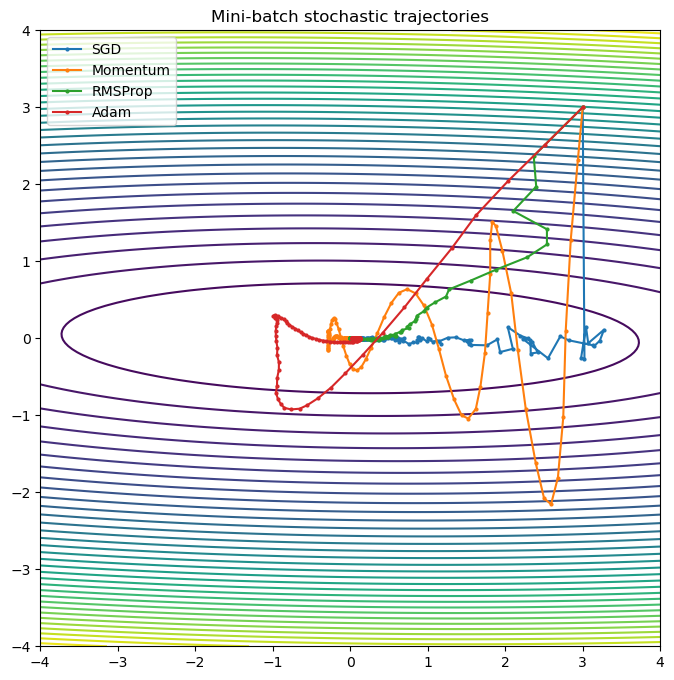

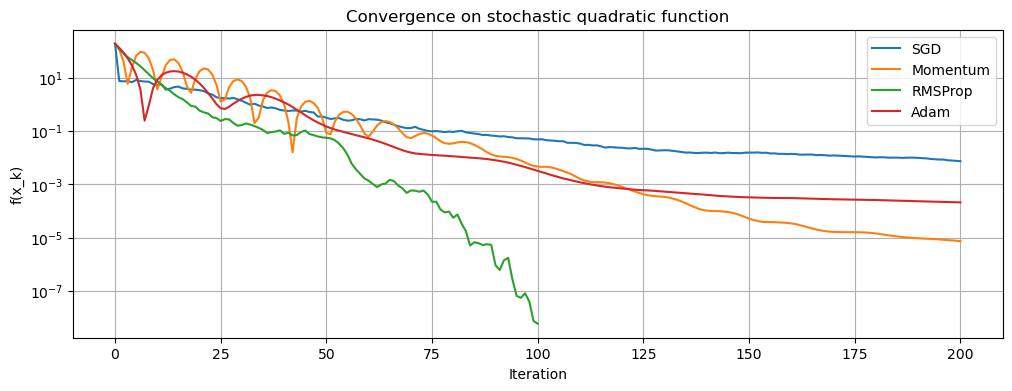

In [61]:
A_list = make_quadratic_dataset()
x0 = np.array([3.0, 3.0])

lr_sgd = np.array([0.05, 0.05])
lr_momentum = np.array([0.1, 0.1])
lr_rmsprop = np.array([0.2, 0.2])
lr_adam = np.array([0.5, 0.5])

traj_sgd = sgd_decay(x0, A_list, lr_sgd)
traj_momentum = momentum_sgd_decay(x0, A_list, lr_momentum, beta=0.9, decay=0.99)
traj_rmsprop = rmsprop_decay(x0, A_list, lr_rmsprop)
traj_adam = adam_decay(x0, A_list, lr_adam)

plot_trajectories(np.mean(A_list, axis=0), [traj_sgd, traj_momentum, traj_rmsprop, traj_adam], ['SGD', 'Momentum', 'RMSProp', 'Adam'])
plot_convergence_stochastic(A_list, [traj_sgd, traj_momentum, traj_rmsprop, traj_adam], ['SGD', 'Momentum', 'RMSProp', 'Adam'])



### Conclusion

- SGD converges the slowest. The function value decreases steadily but very gradually. High noise and lack of adaptivity make it the least efficient method.

- Momentum converges faster than SGD, shows noticeable oscillations, but the overall trend is downward. Performs better in ill-conditioned settings but still lags behind adaptive methods.

- RMSProp achieves the fastest and most aggressive decrease in the objective. Quickly drives the function value to a very small level. However, after the sharp descent, the trajectory becomes unstable, showing strong oscillations and occasional increases.

- Adam is nearly as fast as RMSProp in the early iterations but significantly more stable. Reaches a low error level and maintains it without large fluctuations. Provides smoother and more reliable convergence overall.